In [255]:
import pandas as pd 
import seaborn as sns  
import matplotlib.pyplot as plt
import re

from datasets import load_dataset


from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
from transformers import pipeline


import spacy
import unicodedata
from spacy.lang.fr.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

from bertopic.representation import OpenAI
import openai
import tiktoken





# Le dataset

In [14]:
data = load_dataset("ekazuki/french_deputies_tweet")["train"]
data

Dataset({
    features: ['twitterId', 'text', 'hasMedia', 'date', 'authorId', 'group'],
    num_rows: 2179
})

In [15]:
data.set_format("pandas")

In [247]:
data[:][data[:].text.str.lower().str.contains("melenchon")]['text'].to_list()

['Tout mon sontien à @JLMelenchon, @Deputee_Obono, @T_Bouhafs et @MatMolard. La République ne peut pas admettre ces appels au meurtre et ces menaces.',
 'Honte aux élus de la #NUPES présents à #SainteSoline auprès des hordes factieuses qui attaquent les forces de l’ordre. \n\n@JLMelenchon @marinetondelier @faureolivier @Fabien_Roussel @MathildePanot @BorisVallaud @AndreChassaigne @Cyrielle_Chtl, ne pas condamner c’est cautionner. https://t.co/58ITXgdIsC',
 "Le but de Macron c'est diviser pour régner. Entre vaccinés et non vaccinés, entre actifs et retraités, entre salariés et chômeurs. Son discours c'est la division générale. Nous c'est l'union populaire avec @JLMelenchon !",
 '@JLMelenchon Qualifier d’ «\xa0extrême droite\xa0» le président du @Le_CRIF, le jour de la commémoration du Vel d’Hiv…Vous avez perdu tous vos repères, à commencer par l’élémentaire dignité.',
 "Il est temps de sonner la grande #mobilisation de tous les #démocrates de ce pays ! \nL'alliance des extrêmes n'est pl

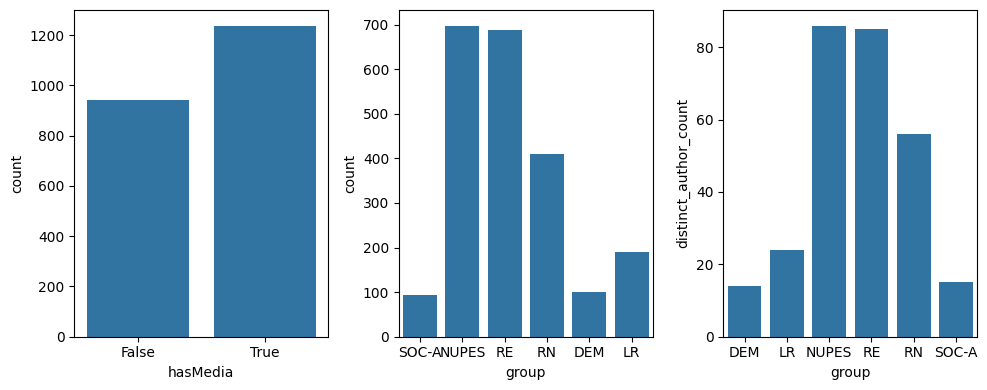

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(10,4))
sns.countplot(data = data[:], x = "hasMedia", ax = ax[0])
sns.countplot(data = data[:], x = "group", ax = ax[1])
sns.barplot(data = data[:][["group", "authorId"]].groupby("group")["authorId"].nunique().reset_index(name='distinct_author_count'),
                 x = "group", y= "distinct_author_count",ax = ax[2])
plt.tight_layout()
plt.show()

In [48]:
data[:][["group", "authorId"]].groupby("group")["authorId"].nunique().reset_index(name='distinct_author_count')


,group,distinct_author_count
0,DEM,14
1,LR,24
2,NUPES,86
3,RE,85
4,RN,56
5,SOC-A,15


# Préprocessing text

In [128]:
tweets = data[:]["text"]

In [62]:
tweets[:2].to_list()

["Du RN à Dussopt, toute la droite et l'extrême-droite se félicite de la victoire d'une députée PS dissidente en Ariège. Pas meilleure preuve que la gauche unie leur fait peur ! Ce n'est pas un avertissement à la #Nupes comme ils le prétendent, c'est tout l'inverse !\n@faureolivier",
 'Je suis candidat à ma réélection lors de la législative partielle dans la #9eCircoFDE ! Ma vidéo aux Français.e.s de ma circo 👇\nAvec le soutien de @GenerationsMvt @EcologistesAN @socialistesAN @FiAssemblee @deputesPCF @placepublique_ @Gauche_RS https://t.co/jo8NQ4QrAz']

In [229]:
# enlever les liens de redirections

nlp = spacy.load("fr_core_news_md")

def process_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = text.replace("\n", " ")
    text = text.replace("@", "")
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_stop])

def remove_stopwords(text):
    words = text.split()  # Diviser le texte en mots
    filtered_words = [word for word in words if word.lower() not in stop_words]
    stop_words_custom = ["est", "nest", "cest", "dun", "du", "tes", "mes",  "sest", "ses", "que", "quun", "qune", "il", "elle", "nous", "vous", "ils", "elles", "le", "la", "les",
    "un", "une", "des", "dans", "avec", "pour", "par", "sur", "en", "de", "se", "et", "a", "mais", "ou", "donc", "or", "ni", "car", "pas", "ne", "plus", "tous", "tout", "toute", "toutes", "lui", "moi", "toi", "son",
    "sa", "mon", "ton", "leur", "leurs", "notre", "nos", "jai"
    "votre", "vos", "ce", "cet", "cette", "ces", "ceux", "cela", "ça", "ci", "là", "y", "on", "si", "sont",  "ai", "as", "avons", "avez", "ont", "es", "étais",  "était", "étions", "étiez", "étaient", "avoir", "être"]

    filtered_words = [word for word in filtered_words if word.lower() not in STOP_WORDS]
    filtered_words = [word for word in filtered_words if word.lower() not in stop_words_custom]
    return ' '.join(filtered_words)

tweets_cleaned = data[:]["text"].apply(process_text).apply(remove_stopwords)
tweets_index = tweets_cleaned.index
tweets_cleaned = tweets_cleaned[tweets_cleaned.apply(lambda x: len(x) > 5)]
filtered_data = data[:].loc[tweets_cleaned.index]
tweets_cleaned = tweets_cleaned.to_list()
tweets_cleaned[:2]


['RN Dussopt droite lextrêmedroite félicite victoire dune députée PS dissidente Ariège meilleure preuve gauche unie peur avertissement Nupes prétendent linverse faureolivier',
 'candidat réélection législative partielle 9eCircoFDE vidéo Françaises circo soutien GenerationsMvt EcologistesAN socialistesAN FiAssemblee deputesPCF placepublique_ Gauche_RS']

In [130]:
['Du RN a Dussopt toute la droite et lextremedroite se felicite de la victoire dune deputee PS dissidente en Ariege Pas meilleure preuve que la gauche unie leur fait peur ! Ce nest pas un avertissement a la Nupes comme ils le pretendent cest tout linverse !faureolivier',
 'Je suis candidat a ma reelection lors de la legislative partielle dans la 9eCircoFDE ! Ma video aux Francaises de ma circo Avec le soutien de GenerationsMvt EcologistesAN socialistesAN FiAssemblee deputesPCF placepublique_ Gauche_RS ']

['Du RN a Dussopt toute la droite et lextremedroite se felicite de la victoire dune deputee PS dissidente en Ariege Pas meilleure preuve que la gauche unie leur fait peur ! Ce nest pas un avertissement a la Nupes comme ils le pretendent cest tout linverse !faureolivier',
 'Je suis candidat a ma reelection lors de la legislative partielle dans la 9eCircoFDE ! Ma video aux Francaises de ma circo Avec le soutien de GenerationsMvt EcologistesAN socialistesAN FiAssemblee deputesPCF placepublique_ Gauche_RS ']

In [260]:
umap_model = UMAP(n_neighbors=5, n_components = 5, min_dist=0.0, metric='cosine', random_state=42)
keybert_model = KeyBERTInspired()
pos_model = PartOfSpeech("fr_core_news_lg")
mmr_model = MaximalMarginalRelevance(diversity=0.3)
client = openai.OpenAI(api_key="sk-...")
tokenizer= tiktoken.encoding_for_model("gpt-3.5-turbo")
openai_generator = OpenAI(
                    client,
                    model="gpt-3.5-turbo", 
                    delay_in_seconds=2, 
                    chat=True,
                    nr_docs=4,
                    doc_length=100,
                    tokenizer=tokenizer
                )

representation_model = {
    #"KeyBERT": keybert_model,
    "OpenAI": openai_generator,  # Uncomment if you will use OpenAI
  #  "MMR": mmr_model,
 #   "POS": pos_model
}

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(tweets_cleaned, show_progress_bar=True)

hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words="french", min_df=2, ngram_range=(1, 2))



Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [261]:
bert_model = BERTopic(

    #pipeline modele
    embedding_model = embedding_model,
    umap_model = umap_model,
    hdbscan_model = hdbscan_model, 
    vectorizer_model = vectorizer_model,
    representation_model = representation_model,
    ctfidf_model = ctfidf_model,
    # hyperparametres
    top_n_words = 10,
    verbose=True
)
topics, probs = topic_model.fit_transform(tweets_cleaned, embeddings)
hierarchical_topics = topic_model.hierarchical_topics(tweets_cleaned)


100%|██████████| 32/32 [00:00<00:00, 1022.88it/s]


In [262]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1007,-1_jai_président_france_contre,"[jai, président, france, contre, faire, député...",[parti Paris Comptez côtés collègues députés R...
1,0,219,0_français_france_emmanuelmacron_pays,"[français, france, emmanuelmacron, pays, prési...","[parti 5 années défendre France Français, soir..."
2,1,72,1_tour_année_2nd_cap,"[tour, année, 2nd, cap, bonne, marseille, gt, ...",[Nantes 2h train Paris PSG préfère venir avion...
3,2,67,2_motion_voter_censure_voterai,"[motion, voter, censure, voterai, réforme, gou...",[Lundi voterai motion censure portée groupe LI...
4,3,65,3_violences_violence_humilié_femmes,"[violences, violence, humilié, femmes, lordre,...",[devons intraitables violences sexistes sexuel...
5,4,49,4_macronistes_covid19_coronavirus_lépidémie,"[macronistes, covid19, coronavirus, lépidémie,...",[quart Français renoncent soins gouvernement d...
6,5,46,5_réforme_députés_retraites_étudiants,"[réforme, députés, retraites, étudiants, retra...",[Réforme retraites Larticle 5 adopté députés m...
7,6,44,6_hamas_gaza_otages_israël,"[hamas, gaza, otages, israël, libération, otag...",[honneur parrainer Carmel Gat 39 ans kidnappée...
8,7,44,7_écologistes_agriculteurs_écologique_agriculture,"[écologistes, agriculteurs, écologique, agricu...",[NUPES NUPES porte combat contre lantisémitism...
9,8,42,8_dune_veut_refus_volonté,"[dune, veut, refus, volonté, jamais, propositi...",[Tomber coup mandat darrêt européen présuppose...


In [259]:
topic_model.visualize_topics()

In [233]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [211]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─dune_hamas_guerre_soutien_violences
│    ├─soutien_racistes_racisme_journaliste_louisboyard
│    │    ├─soutien_racistes_racisme_journaliste_raciste
│    │    │    ├─■──émotion_couples_psychologique_interdites_laccompagnement ── Topic: 27
│    │    │    └─racistes_racisme_journaliste_soutien_raciste
│    │    │         ├─■──racistes_racisme_raciste_xénophobes_discriminations ── Topic: 14
│    │    │         └─■──journaliste_journalistes_soutien_sen_chrétienne ── Topic: 24
│    │    └─louisboyard_tpmp_plateau_bolloré_médiatique
│    │         ├─■──louisboyard_tpmp_bolloré_insultes_insulte ── Topic: 33
│    │         └─■──plateau_médiatique_médias_assourdissant_mépris ── Topic: 25
│    └─dune_hamas_guerre_violences_contre
│         ├─hamas_dune_violences_guerre_police
│         │    ├─hamas_gaza_otages_israël_terroristes
│         │    │    ├─■──islamiste_islamistes_lantisémitisme_voile_détude ── Topic: 17
│         │    │    └─■──hamas_gaza_otages_israël_libération ── Topic: 5
│    

In [234]:
topic_model.visualize_hierarchical_documents(tweets_cleaned, hierarchical_topics, embeddings=embeddings)

reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_hierarchical_documents(tweets_cleaned, hierarchical_topics, reduced_embeddings=reduced_embeddings)


In [237]:
topic_model.visualize_documents(filtered_data.group.to_list(), reduced_embeddings=reduced_embeddings, custom_labels=False)